In [1]:
# Install packages
library(tidyverse)
library(BB)
library(ggplot2)
library(readxl)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
# Compute the prior
prior_set <- function(limits, shape, quantiles){
    
    # Function to optimize
    test <- pbeta(q = limits, shape1 = shape[1], shape2 = shape[2]) - quantiles
    
    # Return statement
    return(test)
    
}

In [24]:
# Compute the posterior and associated statistics
posterior_compute <- function(limits, quantiles, n, x){

    # Create sequence of parameters that we will use to plot on X-axis
    th <- seq(0,1, length = 500)

    # Compute the prior's shape using BBSolve based on the given limits and quantiles
    prior_shape <- BBsolve(par = c(1,1), fn = prior_set, limits = limits, quantiles = quantiles)$par

    # First shape parameter
    a <- prior_shape[1]
    
    # Second shape parameter
    b <- prior_shape[2]

    # Compute the prior using the shape
    prior <- dbeta(th, a, b)

    # Set the likelihood 
    likelihood <- dbeta(th, x + 1, n - x + 1)

    # Set the posterior
    posterior <- dbeta(th, x + a, n - x + b)

    # Plot the prior
    plot(th, posterior, ylab = "Density", type = 'l', lty = 1, lwd = 1, xlab = expression(theta))

    # Plot the likelihood
    lines(th, likelihood, ylab = "Density", type = 'l', lty = 2, lwd = 1, xlab = expression(theta))

    # Plot the posterior
    lines(th, prior, ylab = "Density", type = 'l', lty = 3, lwd = 1, xlab = expression(theta))

    # Add a legend
    legend(0.1, 4, c("Posterior", "Likelihood", "Prior"), lty = c(1, 2, 3), lwd = c(1,1,1))

    # Store the posterior mean
    posterior_mean <- (x + a)/(a + n + b)
    
    # Store the posterior variance
    posterior_variance <- (x + a)*(n - x + b)/(a + n + b)^2*(a + n +b +1)  
    
    # Posterior standard error
    posterior_se <- sqrt(posterior_variance)
    
    # Store as a list to enable multi-item returns
    posterior_stats <- list(posterior_mean, posterior_variance, posterior_se)
    
    # Return the posterior mean
    return(posterior_stats)

}

In [25]:
# Helper function to prepare sample and prior data
data_prep <- function(path, sheet, player){
    
    # Load data
    data <- read_xlsx(path = path, sheet = sheet)
    
    # Get win data
    wins <- filter(data, grepl(player, Winner))
    
    # Get losses data
    losses <- filter(data, grepl(player, Loser))
    
    # Count wins
    x = dim(wins)[1]
    
    # Get total matches played
    n = x + dim(losses)[1]
    
    # Store record in a vector
    record = list(x, n)
    
    # Return the record
    return(record)
}

In [28]:
# Implement the entire process with flat prior as default
bayes_compute <- function(path0 = '~/Documents/Code/beta_bin/2018.xlsx',
                          path1 = '~/Documents/Code/beta_bin/2017.xlsx', sheet = 1, 
                          player = 'Djokovic', limits = c(0.5, 1), quantiles = c(0.5, 1)){

    # Store sample data
    sample_data = suppressWarnings(data_prep(path = path0, sheet = sheet, player = player))
        
    # Store sample wins
    x = sample_data[[1]]

    # Store sample total 
    n = sample_data[[2]]
        
    # Prior data
    prior_data <- suppressWarnings(data_prep(path = path1, sheet = sheet, player = player))
    
    # Store prior wins
    x0 = prior_data[[1]]
    
    # Store prior total
    n0 = prior_data[[2]]
    
    # Prior win rate
    prior_win_rate <- x0/n0
     
    # Reset the limits to account for prior win rate - empirical Bayes!
    limits = c(prior_win_rate, 1)
    
    # Compute the posterior
    posterior_stats <- posterior_compute(limits = limits, quantiles = quantiles, n, x)
    
    # Return the posterior mean
    return(posterior_stats)
}

  Successful convergence.


[[1]]
[1] 0.6697874

[[2]]
[1] 6.614079

[[3]]
[1] 2.571785

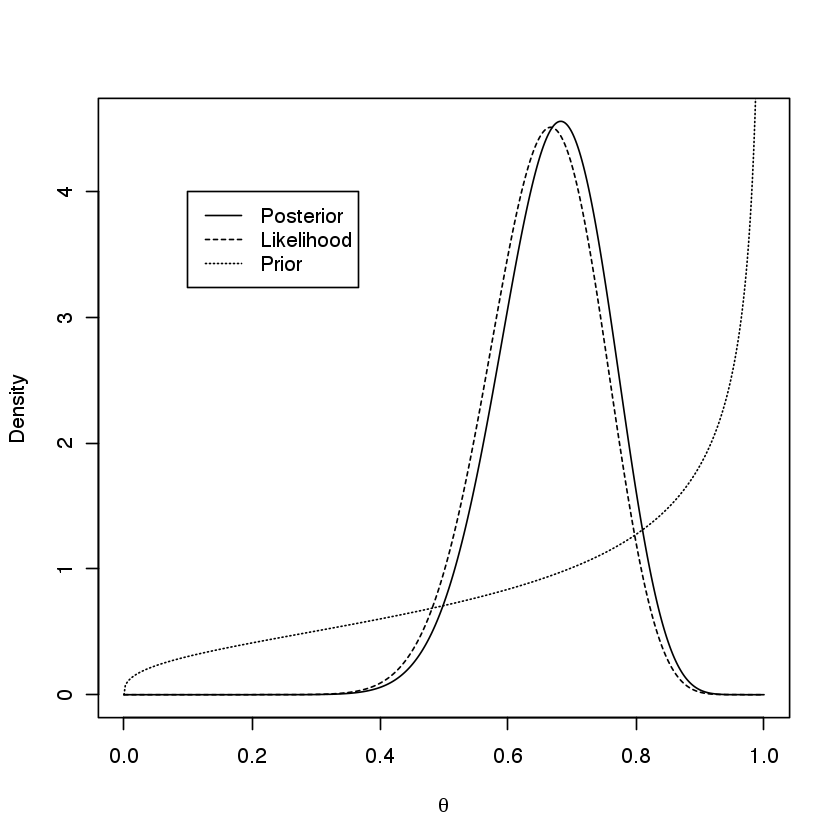

In [29]:
test = bayes_compute()
test